### [Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)
- Classic multipurpose classifiers
- [Linear](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) and [Quadratic](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis) decision surface solvers available.
- No parameter tuning required.

### Dimensional Reduction using Linear DA
- Works by projecting input data to a **linear subspace** containing axes that maximize the distance between classes.
- Uses the `transform` method.
- Desired #dimensions can be set using `n_components` (has no impact on the `fit` and `predict` methods.

### Example: LDA/PCA comparison - Iris dataset

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
iris = load_iris()
X,y,targets = iris.data, iris.target, iris.target_names

In [3]:
pca = PCA(n_components=2)
lda = LDA(n_components=2)

Xpca = pca.fit(X).transform(X)
Xlda = lda.fit(X,y).transform(X)

In [8]:
#print(Xpca)

Text(0.5, 1.0, 'PCA/IRIS')

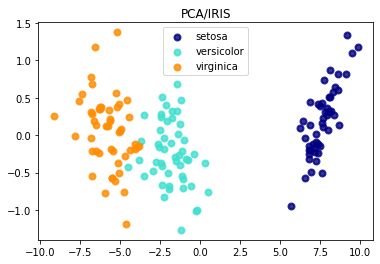

In [12]:
# PCA finds the attributes that account for the most variance in
# the IRIS dataset. Here we plot the samples on the 1st two
# principal components.

plt.figure()
colors=['navy','turquoise','darkorange']; lw=2

for color,i,name in zip(colors,[0,1,2],targets):
    plt.scatter(Xlda[y==i,0],
                Xpca[y==i,1],
                color=color, alpha=0.8, lw=lw, label=name)

plt.legend(loc='best',shadow=False,scatterpoints=1)
plt.title('PCA/IRIS')

Text(0.5, 1.0, 'LDA/IRIS')

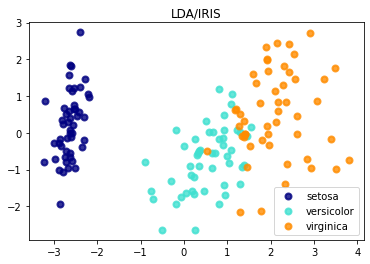

In [11]:
# LDA finds the attributes that account for the most variance 
# BETWEEN CLASSES in the IRIS dataset. Also note that LDA is a
# supervised method, where PCA is unsupervised.
plt.figure()
for color,i,name in zip(colors,[0,1,2],targets):
    plt.scatter(Xpca[y==i,0],
                Xlda[y==i,1],
                color=color, alpha=0.8, lw=lw, label=name)

plt.legend(loc='best',shadow=False,scatterpoints=1)
plt.title('LDA/IRIS')

### Math foundations
- LDA & QDA model a conditional distribution ($P(X|y=k)$) for each class $k$. Predictions are based on a Bayes rule; we select $k$ which returns a max posterior probability.
- $P(x|y)$ is defined as a multivariate Gaussian distribution:
$P(x | y=k) = \frac{1}{(2\pi)^{d/2} |\Sigma_k|^{1/2}}\exp\left(-\frac{1}{2} (x-\mu_k)^t \Sigma_k^{-1} (x-\mu_k)\right)$, where $d$ is the number of features.
- If the QDA model assumes that the covariance matrices are diagonal, then the inputs are assumed to be _conditionally independent_ in each class - so the resulting classifier model is equivalent to a [Gaussian Naive Bayes classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB).
- LDA is a special case of QDA where the Gaussians for each class _share the same covariance matrix for all $k$._ This reduces the log posterior function to: 
$\log P(y=k | x) = -\frac{1}{2} (x-\mu_k)^t \Sigma^{-1} (x-\mu_k) + \log P(y = k) + Cst.$.
- $(x-\mu_k)^t \Sigma^{-1} (x-\mu_k)$ is the __[Mahalanobis Distance](https://en.wikipedia.org/wiki/Mahalanobis_distance)__ between a sample $x$ and the mean $\mu_k$. LDA assigns $x$ to the class that is closest in (Mahaloanobis) distance.

### Shrinkage
- A type of regularization - it improves covariance matrix estimation (generalization performance) when the #samples << #features.
- Can be set using the `shrinkage` param to 'auto', which uses the Ledoit/Wolf lemma to find an optimal setting. (Note: currently, shrinkage only works when the `solver` param is set to 'lsqr' or 'eigen'.
- Can also be manually set between 0-1.
    - 0 = no shrinkage = use the empirical covariance matrix
    - 1 = full shrinkage = use the diagonal variance matrix 
- If data is normally distributed, the [Oracle Shrinkage Approximating](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.OAS.html#sklearn.covariance.OAS) estimator returns a smaller MSE than Ledoit/Wolf. 
- Covariance estimators are set using `covariance_estimator`. Estimators should have a `fit` method and a `covariance_` attribute.

### Example: Covariance estimator comparison for LDA classification

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs as Blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.covariance import OAS

In [16]:
n_train, n_test, n_avgs, n_max_features, step = 20,200,50,75,4

# generate noisy data blob
# returns array(nsamples,nfeatures) and array(nlabels)
# one distinctive feature - rest is noise

def generate_data(n_samples,n_features):
    X,y = Blobs(n_samples=n_samples, n_features=1,
                centers=[[-2],[+2]])
    # add non-distinctive features
    if n_features>1:
        X = np.hstack([X,np.random.randn(n_samples,n_features-1)])
    return X,y

In [19]:
acum_clf1, acum_clf2, acum_clf3 = [],[],[]

In [18]:
n_features_range=range(1,n_max_features+1,step)

In [20]:
for n_features in n_features_range:
    score_clf1,score_clf2,score_clf3 = 0,0,0
    
    for _ in range(n_avgs):
        X,y = generate_data(n_train,n_features)
        
        clf1 = LDA(solver='lsqr', shrinkage='auto').fit(X,y)
        clf2 = LDA(solver='lsqr', shrinkage=None).fit(X,y)
        oa   = OAS(store_precision=False, assume_centered=False)
        clf3 = LDA(solver='lsqr', covariance_estimator=oa).fit(X,y)

        X,y = generate_data(n_test,n_features)
        score_clf1 += clf1.score(X,y)
        score_clf2 += clf2.score(X,y)
        score_clf3 += clf3.score(X,y)
        
    acum_clf1.append(score_clf1/n_avgs)
    acum_clf2.append(score_clf2/n_avgs)
    acum_clf3.append(score_clf3/n_avgs)

In [21]:
features_to_samples_ratio = np.array(n_features_range)/n_train

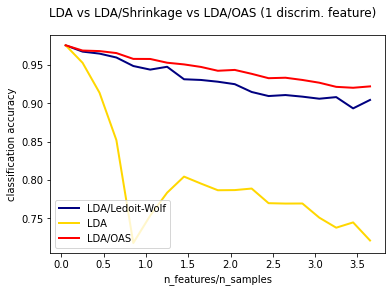

In [25]:
plt.plot(features_to_samples_ratio, acum_clf1, linewidth=2,
        label="LDA/Ledoit-Wolf", color='navy')
plt.plot(features_to_samples_ratio, acum_clf2, linewidth=2,
        label="LDA",             color='gold')
plt.plot(features_to_samples_ratio, acum_clf3, linewidth=2,
        label="LDA/OAS",         color='red')

plt.xlabel('n_features/n_samples')
plt.ylabel('classification accuracy')
plt.legend(loc=3)
plt.suptitle("LDA vs LDA/Shrinkage vs LDA/OAS (1 discrim. feature)")
plt.show()

### Estimators
- LDA & QDA modeling requires computing a log-posterior. The dependencies are the class priors ($P(y=k)$), class means ($u_k$) and the covariance matrices.
- __svd__ is the default solver for LDA, and the _only_ solver for QDA. Since it does not rely on computing a covariance matrix, __svd__ is preferred for problems with large #features.
    - __svd__ cannot be used with shrinkage.
    - Two SVDs are computed during LDA: one for centered input matrix __X__, another for the class-wise mean vectors.

- __lsqr__ only works for classification problems. It computes the covariance matrix, supports shrinkage, and support custom covariance estimators.

- The __eigen__ solver is uses optimization of a _between-class scatter_ / _within-class scatter_ ratio.
    - __eigen__ can be used for both classifications & regressions.
    - __eigen__ supports shrinkage.
    - __eigen__ needs to compute the covariance matrix, therefore may not be ideal for problems with large #features.